In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from astropy import wcs
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib

In [2]:
def ThetaPhitoDeclRa(theta,phi):
    dec = -1*np.degrees(theta)+90
    ra  = np.degrees(phi)
    ra[ra>180] = -360 + ra[ra>180]
    return dec,ra

In [19]:
latmin = 50
latmax = 70
lonmin = 10
lonmax = 50

def get_peakinfo(filename):
    peakfile = fits.open(filename)
    peakinfo = peakfile[0].data
    rot_angle = peakinfo[:,3]
    theta,phi = peakinfo[:,1], peakinfo[:,2]
    dec,ra = ThetaPhitoDeclRa(theta,phi)

    ra = np.asarray(ra)
    dec = np.asarray(dec)
    in_region = (ra>lonmin) & (ra < lonmax) & (dec < latmax) & (dec > latmin)
    dec = dec[in_region]
    rot_angle = rot_angle[in_region]
    ra = ra[in_region]
    return (rot_angle,ra,dec)

def read_amp_map(amp_file):
    amp_map = fits.open(amp_file)
    amp_map[1].header['TTYPE3'] = 'ID2'
    amp_map.writeto(amp_file, overwrite=True)
    amp_map.close()
    return hp.read_map(amp_file, field=0)

In [26]:
rot_angle_all, ra_all, dec_all = get_peakinfo("/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/orient_tests/0/Websky_massgt1e+13lt5e+13_reg0_432_932Mpc_20pt0_all_pks.fits")
rot_angle_75, ra_75, dec_75 = get_peakinfo("/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/orient_tests/0/Websky_massgt1e+13lt5e+13_reg0_432_932Mpc_20pt0_75pct_pks.fits")
rot_angle_50, ra_50, dec_50 = get_peakinfo("/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/orient_tests/0/Websky_massgt1e+13lt5e+13_reg0_432_932Mpc_20pt0_50pct_pks.fits")
rot_angle_25, ra_25, dec_25 = get_peakinfo("/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/orient_tests/0/Websky_massgt1e+13lt5e+13_reg0_432_932Mpc_20pt0_25pct_pks.fits")



In [11]:
odmap_all   = hp.read_map('/mnt/scratch-lustre/mlokken/pkpatch/number_density_maps/fullsky/galaxies/orient_tests/odmap_all_distMpc_432_932.fits')
odmap_all_s = hp.smoothing(odmap_all, fwhm=np.deg2rad(100/60.))

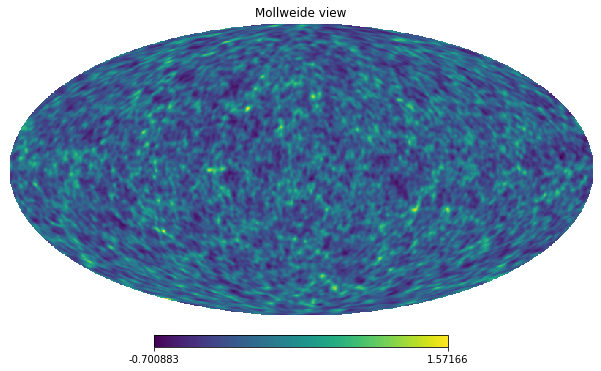

In [12]:
hp.mollview(odmap_all_s)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


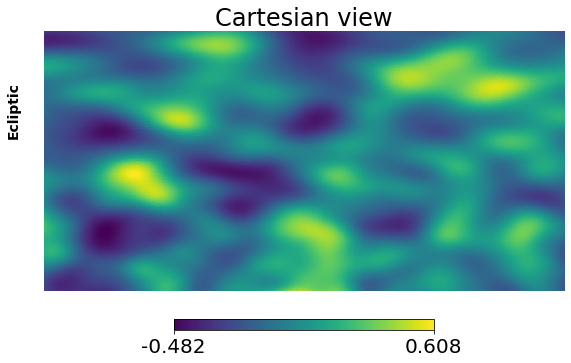

In [22]:
odmap_flat_all = hp.cartview(odmap_all_s, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E')

In [23]:
w = wcs.WCS(naxis=2)

height = float(odmap_flat_all.shape[0])
length = float(odmap_flat_all.shape[1])
w = wcs.WCS(naxis=2)
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmin-latmax)/height, (latmin+latmax)/2.

w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]


[400. 200.]
[30. 60.]
[-0.05 -0.05]


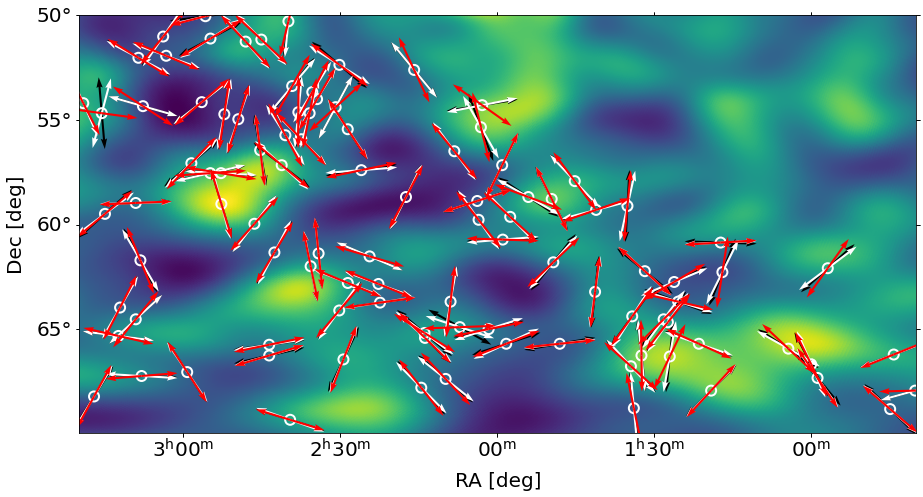

In [73]:
choice = np.random.choice(np.arange(len(ra_all)), size=100, replace=False)
Xpix,Ypix = w.all_world2pix(ra_all,dec_all,0)
Xpix,Ypix = Xpix[choice], Ypix[choice]
def get_vector_components(rot_angle):
    U_arr = np.zeros(len(rot_angle))
    V_arr = np.zeros(len(rot_angle))
    m = 0
    for r in rot_angle:

        if (r <= np.pi/2.) or (r > 3*np.pi/2.):
            U = 1/np.sqrt(1+np.tan(r)**2)
        else:
            U = -1/np.sqrt(1+np.tan(r)**2)
        V = U * np.tan(r)
        U_arr[m] = U
        V_arr[m] = V
        m += 1
    return U_arr, V_arr

# Make the figure

plt.figure(figsize=(15,10))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

nrows = 1
ax1 = plt.subplot(nrows, 1, 1, projection=w)
ax1.imshow(odmap_flat_all[::-1])
# ax = plt.subplot(projection=w)
plt.xlabel("RA [deg]")
ax1.set_ylabel("Dec [deg]")

U_arr_all, V_arr_all = get_vector_components(rot_angle_all[choice])
ax1.quiver(Xpix,Ypix, -U_arr_all, V_arr_all, width=0.0025, color = 'k', scale_units = 'inches', scale = 2)
ax1.quiver(Xpix,Ypix, U_arr_all, -V_arr_all, width=0.0025, color = 'k', scale = 2, scale_units = 'inches')
ax1.scatter(Xpix,Ypix, s=100, edgecolor='w', facecolor='none', linewidths=2)

U_arr_50, V_arr_50 = get_vector_components(rot_angle_50[choice])
ax1.quiver(Xpix,Ypix, -U_arr_50, V_arr_50, width=0.0025, color = 'w', scale_units = 'inches', scale = 2)
ax1.quiver(Xpix,Ypix, U_arr_50, -V_arr_50, width=0.0025, color = 'w', scale = 2, scale_units = 'inches')

U_arr_25, V_arr_25 = get_vector_components(rot_angle_25[choice])
ax1.quiver(Xpix,Ypix, -U_arr_25, V_arr_25, width=0.0025, color = 'r', scale_units = 'inches', scale = 2)
ax1.quiver(Xpix,Ypix, U_arr_25, -V_arr_25, width=0.0025, color = 'r', scale = 2, scale_units = 'inches')


(array([412., 369., 364., 484., 292., 404., 396., 367., 438., 322.]),
 array([-1.57004464, -0.94185859, -0.31367254,  0.3145135 ,  0.94269955,
         1.5708856 ,  2.19907165,  2.82725769,  3.45544374,  4.08362979,
         4.71181583]),
 <BarContainer object of 10 artists>)

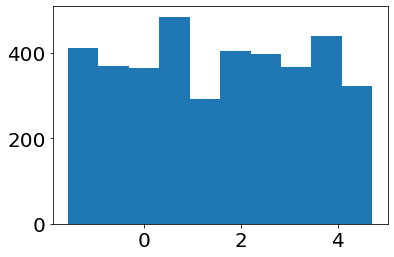

In [76]:
plt.hist(rot_angle_all)
# rot angle goes from -pi/2 to 3pi/2

(array([1.955e+03, 2.000e+00, 0.000e+00, 0.000e+00, 8.920e+02, 9.810e+02,
        1.000e+00, 1.000e+00, 0.000e+00, 1.600e+01]),
 array([2.34842300e-05, 6.27424705e-01, 1.25482593e+00, 1.88222715e+00,
        2.50962837e+00, 3.13702959e+00, 3.76443081e+00, 4.39183203e+00,
        5.01923325e+00, 5.64663447e+00, 6.27403569e+00]),
 <BarContainer object of 10 artists>)

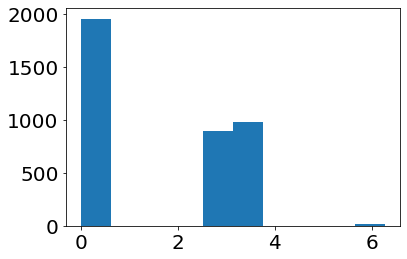

In [74]:
plt.hist(abs(rot_angle_all-rot_angle_50))

In [85]:
def calc_offsets(rot_angle):
    diffs = []
    for i in range(len(rot_angle)):
        a = rot_angle[i] - rot_angle_all[i]
        a = (a + np.pi) % (2*np.pi) - np.pi
        diffs.append(abs(a))
    diffs = np.asarray(diffs)
    diffs[diffs>(np.pi/2.)]-=np.pi
    diffs = np.abs(diffs)
    return diffs

offsets_75 = calc_offsets(rot_angle_75)
offsets_50 = calc_offsets(rot_angle_50)
offsets_25 = calc_offsets(rot_angle_25)


(array([3.73e+03, 9.90e+01, 1.10e+01, 1.00e+00, 2.00e+00, 0.00e+00,
        2.00e+00, 1.00e+00, 1.00e+00, 1.00e+00]),
 array([7.22706318e-06, 1.30610399e-01, 2.61213571e-01, 3.91816743e-01,
        5.22419915e-01, 6.53023086e-01, 7.83626258e-01, 9.14229430e-01,
        1.04483260e+00, 1.17543577e+00, 1.30603895e+00]),
 <BarContainer object of 10 artists>)

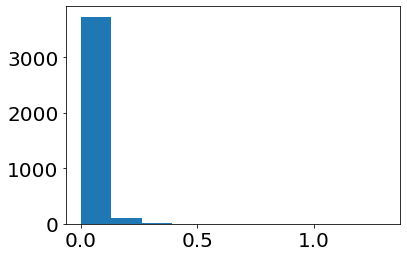

In [86]:
plt.hist(offsets_75)

(array([3.631e+03, 1.730e+02, 2.500e+01, 9.000e+00, 6.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.13551051e-05, 1.36808917e-01, 2.73596480e-01, 4.10384042e-01,
        5.47171604e-01, 6.83959167e-01, 8.20746729e-01, 9.57534291e-01,
        1.09432185e+00, 1.23110942e+00, 1.36789698e+00]),
 <BarContainer object of 10 artists>)

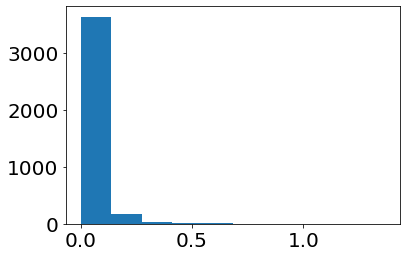

In [87]:
plt.hist(offsets_50)

(array([3.307e+03, 3.790e+02, 8.000e+01, 2.900e+01, 1.500e+01, 1.400e+01,
        4.000e+00, 3.000e+00, 8.000e+00, 9.000e+00]),
 array([2.86102295e-05, 1.54789442e-01, 3.09550273e-01, 4.64311105e-01,
        6.19071937e-01, 7.73832768e-01, 9.28593600e-01, 1.08335443e+00,
        1.23811526e+00, 1.39287609e+00, 1.54763693e+00]),
 <BarContainer object of 10 artists>)

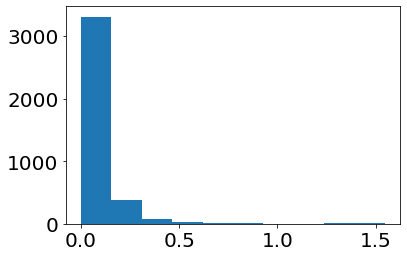

In [88]:
plt.hist(offsets_25)

In [89]:
np.average(offsets_75)*u.rad.to(u.deg)

1.8635359058564076

In [90]:
np.average(offsets_50)*u.rad.to(u.deg)

2.72320984356426

In [91]:
np.average(offsets_25)*u.rad.to(u.deg)

5.170447541901113